In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde, norm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from scipy.stats import norm
from pypalettes import load_cmap
import geopandas as gpd
import contextily as ctx
from matplotlib.patches import FancyArrowPatch
import scipy.io as sio
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors

In [2]:
cmap1 = load_cmap("ClaudeMonet")
cmap_discrete = cmap1


# Function to interpolate the colormap with cubic interpolation
def interpolate_cmap(cmap, num_interp_points):
    new_colors = cmap(np.linspace(0, 1,cmap.N))  
    new_cmap = LinearSegmentedColormap.from_list('my_interpolated_cmap', new_colors, N=num_interp_points)
    return new_cmap


In [3]:
'''
# Indices of the fnew_unique_flush matrix used for plotting the Pareto frontier
index_firm_maxflushing = np.array([32], dtype=np.uint8)
index_sediment_maxflushing = np.array([295], dtype=np.uint16)
index_hydro_maxflushing = np.array([0], dtype=np.uint16)
indices_other = np.array([3,  52,   2,  25,  44,  12,  65,  15,  31,  46,  20,  24,  13,
                    38,  45,  17,  64,  36,  21,   9,   5, 132,  42,  58,   7,  30,
                    16,  34, 119,  10,   8,  19,   4,  14,  11, 109,  22,  33,  18,
                    1,  47,  23,  39,  56,   6,  37,   0], dtype=np.uint16) 
indices_1year = np.array([  120, 160, 126, 101, 230, 114, 271, 141, 112, 108, 174, 118, 222,
                    135, 280, 170, 194, 264, 172, 137, 122, 144, 228, 117, 121, 163,
                    275,  87, 115, 249, 189, 223, 127, 149, 185, 200, 156, 265, 181,
                    116, 102, 218, 193, 136, 279, 217, 236, 254, 253, 134,  84, 238,
                    99, 259, 184, 229,  93, 224, 168, 262, 241, 173, 157, 261,
                    176, 191, 186, 153, 138, 257, 161, 201, 129, 235, 216, 208, 158,
                    268, 196, 183, 209, 148, 206,  89, 123, 175, 167,  96,  97, 177,
                    256, 277, 187, 306,  94, 304, 240,  92, 225,  74, 171, 207, 150,
                    278, 237, 125, 147,  61, 221, 260, 211,  69, 198, 124, 110, 266,
                    63, 263, 226, 300, 182,  90, 130, 274, 111, 169, 105, 281, 104,
                    91, 305, 290, 293, 297, 202, 227, 190,  76, 142, 107, 303,  59,
                    284, 291, 219, 294, 258, 151,  95, 162, 296, 243, 288,  98, 188,
                    143, 178, 269, 283, 301, 197, 299, 295, 205, 146, 247, 215,
                    180, 239, 307, 272,  82, 252, 282, 179, 234, 203, 100, 287, 199,
                    285, 270,  88, 165, 195, 298,  85, 286, 154, 273, 131, 139, 164,
                    289, 302, 267, 166,  60,  51, 292,  62,  77, 133, 276, 213],
                    dtype=np.uint16)
indices_2years = np.array([ 244, 152, 140, 103, 210,  83, 220, 214,  81,  55, 159, 128,  71,
                    155, 255,  72, 245,  68,  27, 145, 212, 106, 232,  57,  28, 192,
                    78,  41, 250, 251, 231,  48,  66,  79,  43,  26,  53,  50, 246,
                    233,  70, 113,  67,  49,  32, 242,  73,  35,  80, 204,  40, 248,
                    29,  54,  75,  86], dtype=np.uint16)
index_compromize1flush = np.array([251], dtype=np.uint8)
index_compromize2flush = np.array([88], dtype=np.uint16)
'''

'\n# Indices of the fnew_unique_flush matrix used for plotting the Pareto frontier\nindex_firm_maxflushing = np.array([32], dtype=np.uint8)\nindex_sediment_maxflushing = np.array([295], dtype=np.uint16)\nindex_hydro_maxflushing = np.array([0], dtype=np.uint16)\nindices_other = np.array([3,  52,   2,  25,  44,  12,  65,  15,  31,  46,  20,  24,  13,\n                    38,  45,  17,  64,  36,  21,   9,   5, 132,  42,  58,   7,  30,\n                    16,  34, 119,  10,   8,  19,   4,  14,  11, 109,  22,  33,  18,\n                    1,  47,  23,  39,  56,   6,  37,   0], dtype=np.uint16) \nindices_1year = np.array([  120, 160, 126, 101, 230, 114, 271, 141, 112, 108, 174, 118, 222,\n                    135, 280, 170, 194, 264, 172, 137, 122, 144, 228, 117, 121, 163,\n                    275,  87, 115, 249, 189, 223, 127, 149, 185, 200, 156, 265, 181,\n                    116, 102, 218, 193, 136, 279, 217, 236, 254, 253, 134,  84, 238,\n                    99, 259, 184, 229,  93, 224,

In [23]:
# Indices of the fnew_unique_flush matrix used for plotting the Pareto frontier
'''  
Obtained by simulating VIRes_CASCADE with each optimal Pareto-optimal reservoir parameterization, and assessing which solutions include LSS2 annual flushing, 
LSS2 flushing every two years, and LSS2 flushing more than every two years
'''
index_firm_maxflushing = np.array([184], dtype=np.uint8)
index_sediment_maxflushing = np.array([285], dtype=np.uint16)
index_hydro_maxflushing = np.array([181], dtype=np.uint16)
indices_other = np.array([48,49,51,113,114,116,125,126,131,132,137,138,139,140,157,158,159,161,162,163,164,165,168,169,181,182,183,184,185,187,188,189,201,202,207,209,211,212,214,233,234,249,291,292,293,301,305], dtype=np.uint16) 
indices_1year = np.array([0,1,6,9,17,21,22,23,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,50,52,55,56,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,100,101,102,103,104,108,109,
                    120,121,122,123,124,127,130,133,134,135,141,142,143,144,146,147,148,149,150,151,152,153,154,155,156,166,167,170,174,175,179,180,186,190,191,192,194,195,196,197,198,199,200,203,204,205,213,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,235,236,237,239,242,243,244,245,246,247,248,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,
                    273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,294,295,296,297,298,299,300,302,303,304,306],
                    dtype=np.uint16)
indices_2years = np.array([2,3,4,5,7,8,10,11,12,13,14,15,16,18,19,20,24,53,54,57,58,59,60,61,62,99,105,106,107,110,111,112,115,117,118,119,128,129,136,145,
                    160,171,172,173,176,177,178,193,206,208,210,238,240,241,307], dtype=np.uint16)
index_compromize1flush = np.array([133], dtype=np.uint16)
index_compromize2flush = np.array([18], dtype=np.uint16)

In [4]:
# Cap values for each indicator (the ones used to normalize the values of each objective between 0 and 1 during the optimization)
maxtotalpro = 10.627501095537942e+06 #hp production
maxfirm = 3.207057309002500e+04 #firm hp
maxsed = 30 #sediment loads

In [5]:
# Reading optimization results for flushing
filename = 'optimization_objectives_flush_final_1.txt'

data = np.loadtxt(filename)
all_data = data



fnew_unique = all_data


#fnew_unique = np.unique(fnew, axis=0)

# For the following plot, we locate sediment objective on the first column, hydro production on the second one, and firm hp on the third
a = fnew_unique[:, 0].copy()
b = fnew_unique[:, 1].copy()
fnew_unique[:, 0] = fnew_unique[:, 2]
fnew_unique[:, 1] = a
fnew_unique[:, 2] = b

fnew_unique_flush = fnew_unique
fnew_unique_flush[:, 0] = (1 - fnew_unique_flush[:, 0]) * maxsed;
fnew_unique_flush[:, 1] = (1 - fnew_unique_flush[:, 1]) * maxtotalpro*10**(-6) * 24 / 15
fnew_unique_flush[:, 2] = (1 - fnew_unique_flush[:, 2]) * maxfirm*24*10**(-3)
print(f"Pareto-efficient points:\n{fnew_unique}")

Pareto-efficient points:
[[ 16.04091     11.82643626 285.49095882]
 [ 15.79707     13.42222781 124.09233613]
 [ 15.51399     13.41892904 178.99228253]
 [ 15.46434     13.57310432  69.48718243]
 [ 15.45966     13.51393039  75.69322317]
 [ 15.54702     13.51284214 180.95269252]
 [ 15.99072     13.28136666 276.74954686]
 [ 15.49926     13.52569716  42.48401645]
 [ 15.50337     13.53168257 167.97103766]
 [ 15.85635     13.38284654  42.48401645]
 [ 15.52563     13.52219434  12.02877399]
 [ 15.53043     13.5186405   13.83447554]
 [ 15.52518     13.49718145  47.31538415]
 [ 15.56064     13.56745899  85.29284367]
 [ 15.53808     13.52636032 104.07875913]
 [ 15.53781     13.54972382 104.07568036]
 [ 15.51663     13.57233914 104.07721974]
 [ 15.95295     13.45837832 206.44417997]
 [ 15.57906     13.34536972 115.94666713]
 [ 15.52353     13.37732024 184.9974332 ]
 [ 15.5217      13.39694286 225.0115024 ]
 [ 15.99894     13.49662032 277.96258422]
 [ 15.73914     13.64878913 233.38423106]
 [ 15.749

In [6]:

max_sediment_index = np.argmax(fnew_unique_flush[:, 0])  # Index of the maximum value in the first column (sediment)
max_hydro_index = np.argmax(fnew_unique_flush[:, 1])     # Index of the maximum value in the second column (hydro)
max_firm_index = np.argmax(fnew_unique_flush[:, 2])      # Index of the maximum value in the third column (firm)

print(f"Maximum of sediment: Index {max_sediment_index}")
print(f"Maximum of hydro: Index {max_hydro_index}")
print(f"Maximum of firm: Index {max_firm_index}")

Maximum of sediment: Index 285
Maximum of hydro: Index 181
Maximum of firm: Index 184


In [7]:
# Historical values of the three objectives
# Obtained simulating VICRes-CASCADE from 2008 to 2022 with the original water rule curve
historicalpro = 13.31259859521568
historicalfirm = 167.6655259864105
historicalsedload = 7.73458307692526

/var/folders/m7/hdv2wgx56_393jmgypswfryr0000gn/T/ipykernel_19974/2912031021.py:129: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter5 = ax.scatter(fnew_unique_flush[index_sediment_maxflushing, 1], fnew_unique_flush[index_sediment_maxflushing, 2], s=460, facecolor=fixed_color5,cmap=cmap,marker='h', edgecolor='red',linewidth=1.3)
/var/folders/m7/hdv2wgx56_393jmgypswfryr0000gn/T/ipykernel_19974/2912031021.py:131: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter6 = ax.scatter(fnew_unique_flush[index_hydro_maxflushing, 1], fnew_unique_flush[index_hydro_maxflushing, 2], s=440, facecolor=fixed_color6,cmap=cmap, marker='P', edgecolor='red',linewidth=1.5)
/var/folders/m7/hdv2wgx56_393jmgypswfryr0000gn/T/ipykernel_19974/2912031021.py:134: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter7 = ax.scatter(fnew_unique_flush[index_firm_maxflushing, 1],

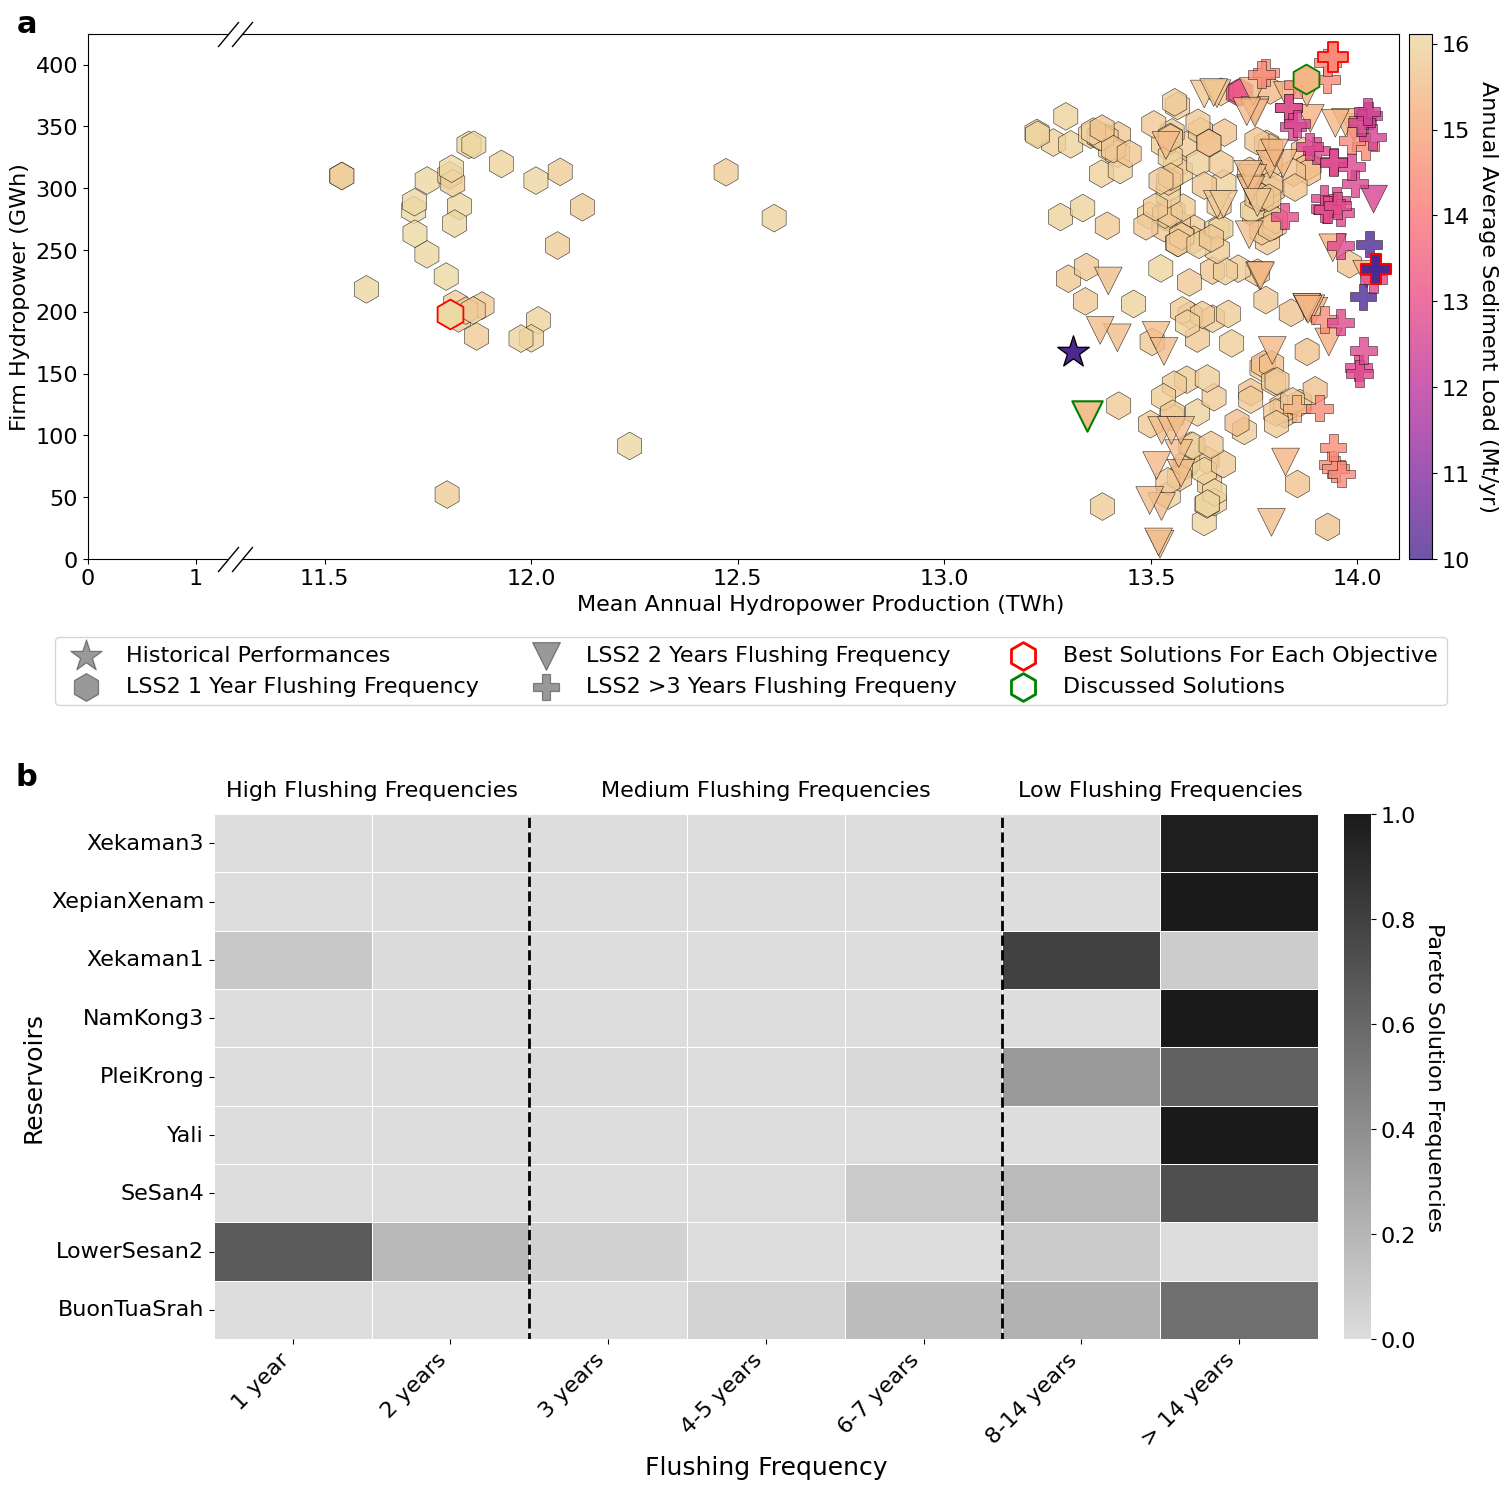

In [37]:
def plot1(ax):
    cmap = load_cmap("borg")
    cmap = cmap.reversed()

    cmap = interpolate_cmap(cmap, 1000)
    # Load data from CSV files
    freq = pd.read_csv('frequencies.csv', header=None)
    freq=freq.T
    # Setting columns names
    freq.columns = ['1 year', '2 years' ,'3 years' , '4-5 years', '6-7 years', '8-14 years', '> 14 years']

    # Setting rows names
    values = ['Xekaman3','XepianXenam','Xekaman1','NamKong3','PleiKrong','Yali','SeSan4', 'LowerSesan2', 'BuonTuaSrah']
    freq.index = values
    
    

    
    ax=sns.heatmap(freq, annot=False, cmap=cmap, linewidths=.6,cbar_kws={'shrink': 1, 'aspect': 20, 'pad': 0.02})
    
    cbar = ax.collections[0].colorbar
    cbar.ax.set_ylabel('Pareto Solution Frequencies', rotation=270, fontsize=16,labelpad=20)
    cbar.ax.tick_params(labelsize=16)
    
    
    freq_high = 2
    freq_low = 4
    freq_never = 6
    xmin, xmax = ax.get_xlim()  
    ymin, ymax = ax.get_ylim()  
    
    ax.axvline(2, -1, 2, color='black', linestyle='--', linewidth=2) 
    ax.axvline(5, -1, 2, color='black', linestyle='--', linewidth=2) 
    
    ax.text(1, -0.3, 'High Flushing Frequencies', ha='center', fontsize=16)
    ax.text(3.5, -0.3, 'Medium Flushing Frequencies', ha='center', fontsize=16)
    
    ax.text(6, -0.3, 'Low Flushing Frequencies', ha='center', fontsize=16)

    ax.set_xticks(range(len(freq.columns)))
    ax.set_xticklabels(freq.columns, rotation=45, fontsize=16)
    ax.set_yticks(range(len(freq.index)))
    ax.set_yticklabels(freq.index, fontsize=16,ha='center')
    # Titles
    ax.set_xlabel('Flushing Frequency', fontsize=18)
    ax.set_ylabel('Reservoirs', fontsize=18)
    

    # Labels
    ax.set_xticks(np.arange(len(freq.columns)) + 0.5)
    ax.set_xticklabels(freq.columns, rotation=45, fontsize=16, ha='right')

    ax.set_yticks(np.arange(len(freq.index)) + 0.5)
    ax.set_yticklabels(freq.index, fontsize=16, va='center',ha='right')



def plot2(ax,a):
    
    cmap = load_cmap("ag_Sunset")
    cmap = interpolate_cmap(cmap, 1000)
    
    
    color_values = fnew_unique_flush[:, 0]
    color_min = 10#color_values.min()
    color_max = color_values.max()
    color_values = np.clip(color_values, color_min, color_max)
    specific_value4 = historicalsedload
    specific_value5 = color_values[index_sediment_maxflushing]
    specific_value6 = color_values[index_hydro_maxflushing]
    specific_value7 = color_values[index_firm_maxflushing]
    specific_value8 = color_values[index_compromize1flush]
    specific_value9 = color_values[index_compromize2flush]
    
    # Normalize the specific value based on the colormap range
    norm = mcolors.Normalize(vmin=color_min, vmax=color_max)
    normalized_value4 = norm(specific_value4)
    normalized_value5 = norm(specific_value5)
    normalized_value6 = norm(specific_value6)
    normalized_value7 = norm(specific_value7)
    normalized_value8 = norm(specific_value8)
    normalized_value9 = norm(specific_value9)

    fixed_color4 = cmap(normalized_value4)
    fixed_color5 = cmap(normalized_value5)
    fixed_color6 = cmap(normalized_value6)
    fixed_color7 = cmap(normalized_value7)
    fixed_color8 = cmap(normalized_value8)
    fixed_color9 = cmap(normalized_value9)
    
 
    c = color_values
    
    scatter_1 = ax.scatter(0,
                            -100,
                            s=570, c='black', alpha=0.4,
                            marker='*',edgecolors='black',linewidth=0.9, label='Historical Performances')

    
    scatter_2 = ax.scatter(0,
                                -100,
                                s=400, c='black', alpha=0.4,
                                marker='h',edgecolors='black',linewidth=0.9, label='LSS2 1 Year Flushing Frequency')

    
    scatter_3 = ax.scatter(0,
                            -100,
                            s=400, c='black', alpha=0.4,
                            marker='v',edgecolors='black',linewidth=0.9, label='LSS2 2 Years Flushing Frequency')

    
    scatter_4 = ax.scatter(0, -100,
                                    s=370, c='black', alpha=0.4, marker='P',edgecolors='black',linewidth=0.9,
                                    label='LSS2 >3 Years Flushing Frequeny')
    scatter_5 = ax.scatter(0, -100,
                                    s=400, c='white', alpha=1, marker='h',edgecolors='red',linewidth=2,
                                    label='Best Solutions For Each Objective')
    scatter_6 = ax.scatter(0, -100,
                                    s=400, c='white', alpha=1, marker='h',edgecolors='green',linewidth=2,
                                    label='Discussed Solutions')
    

    

    scatter1 = ax.scatter(fnew_unique_flush[indices_1year, 1], fnew_unique_flush[indices_1year, 2], s=400, c=c[indices_1year],cmap=cmap,marker='h',alpha=0.8, edgecolor='black', linewidth=0.4, norm=norm)
    scatter2 = ax.scatter(fnew_unique_flush[indices_2years, 1], fnew_unique_flush[indices_2years, 2], s=400, c=c[indices_2years],cmap=cmap, marker='v',alpha=0.8, edgecolor='black', linewidth=0.4, norm=norm)
    scatter3 = ax.scatter(fnew_unique_flush[indices_other, 1], fnew_unique_flush[indices_other, 2], s=370, c=c[indices_other],cmap=cmap, marker='P',alpha=0.8, edgecolor='black', linewidth=0.4, norm=norm)
    
    scatter5 = ax.scatter(fnew_unique_flush[index_sediment_maxflushing, 1], fnew_unique_flush[index_sediment_maxflushing, 2], s=460, facecolor=fixed_color5,cmap=cmap,marker='h', edgecolor='red',linewidth=1.3)
    #ax.plot(fnew_unique_flush[indice_sediment_maxflushing, 1], fnew_unique_flush[indice_sediment_maxflushing, 2], 'o', markersize=12, linewidth=1.7, markerfacecolor='none', markeredgecolor='r')
    scatter6 = ax.scatter(fnew_unique_flush[index_hydro_maxflushing, 1], fnew_unique_flush[index_hydro_maxflushing, 2], s=440, facecolor=fixed_color6,cmap=cmap, marker='P', edgecolor='red',linewidth=1.5)
    #ax.plot(fnew_unique_flush[indice_hydro_maxflushing, 1], fnew_unique_flush[indice_hydro_maxflushing, 2], 's', markersize=12, linewidth=1.7, markerfacecolor='none', markeredgecolor='r')

    scatter7 = ax.scatter(fnew_unique_flush[index_firm_maxflushing, 1], fnew_unique_flush[index_firm_maxflushing, 2], s=440, facecolor=fixed_color7, cmap=cmap, marker='P', edgecolor='red',linewidth=1.3)
    #ax.plot(fnew_unique_flush[indice_firm_maxflushing, 1], fnew_unique_flush[indice_firm_maxflushing, 2], 's', markersize=12, linewidth=1.7, markerfacecolor=l[indice_firm_maxflushing], markeredgecolor='red')
    scatter8 = ax.scatter(fnew_unique_flush[index_compromize1flush, 1], fnew_unique_flush[index_compromize1flush, 2], s=460, facecolor=fixed_color8,cmap=cmap, marker='h', edgecolor='green',linewidth=1.3)
    #ax.plot(fnew_unique_flush[indicecompromize1flush, 1], fnew_unique_flush[indicecompromize1flush, 2], '^', markersize=12, linewidth=1.7, markerfacecolor='none', markeredgecolor=[0.0588, 0.3608, 0.0314])
    scatter9 = ax.scatter(fnew_unique_flush[index_compromize2flush, 1], fnew_unique_flush[index_compromize2flush, 2], s=480, facecolor=fixed_color9,cmap=cmap,marker='v', edgecolor='green',linewidth=1.5)
    scatter4 = ax.scatter(historicalpro, historicalfirm, s=570, facecolor=fixed_color4,cmap=cmap, marker='*', edgecolor='black')
    #ax.plot(fnew_unique_flush[indicecompromize2flush, 1], fnew_unique_flush[indicecompromize2flush, 2], 'o', markersize=12, linewidth=1.7, markerfacecolor='none', markeredgecolor=[0.0588, 0.3608, 0.0314])

    if a == 0:
        ax.set_ylabel('Firm Hydropower (GWh)', fontsize=16)
        ax.set_ylim([0, 17700 * 10**(-3) * 24])
        ax.tick_params(axis='both', which='major', labelsize=16)



    if a == 1:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.1)
    
        cb = plt.colorbar(scatter1, cax=cax)
        cb.mappable.set_clim(color_min, color_max)
        cb.set_label('Annual Average Sediment Load (Mt/yr)', fontsize=16, rotation=270, labelpad=20)
        cb.ax.tick_params(labelsize=16)

        ax.set_xlabel('Mean Annual Hydropower Production (TWh)', fontsize=16)
        #ax.set_ylabel('Firm Hydropower (GWh)', fontsize=16)
        ax.set_ylim([0, 17700 * 10**(-3) * 24])
        ax.set_xlim([11.2, 14.2])
        ax.tick_params(axis='both', which='major', labelsize=16)
    #brokenaxes(xlims=((0, 1), (13, 15.1)), hspace=0.05)  
    
        #ax.set_xlim([13 , 15.1])
        #ax.tick_params(axis='both', which='major', labelsize=16)
        ax.set_yticks([])  # Nasconde i tick sull'asse y
        ax.set_yticklabels([]) 
    
        legend = ax.legend(fontsize=16,loc='lower center', bbox_to_anchor=(0.44, -0.3), ncol=3)
        legend.set_title(None)
    
    

    
    

    



fig = plt.figure(figsize=(14, 15))
'''
left = -0.08
bottom = 1
width = 0.95
height = 0.35
'''
left1 = -0.08  
bottom = 1
width1 = 0.1
height = 0.35
ax3_1 = fig.add_axes([left1, bottom, width1, height])

left2 = 0.03 
width2 = 0.85
ax3_2 = fig.add_axes([left2, bottom, width2, height])


plt.sca(ax3_1)
plot2(ax3_1,0)
ax3_1.set_xlim(0, 1.3)  

plt.sca(ax3_2)
plot2(ax3_2,1)
ax3_2.set_xlim(11.3, 14.1)  

ax3_1.spines['right'].set_visible(False)
ax3_2.spines['left'].set_visible(False)

d = 1.2  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=18,
            linestyle='none',color='k', mec='k', mew=1, clip_on=False)
ax3_1.plot([1, 1], [0, 1], transform=ax3_1.transAxes, **kwargs)
ax3_2.plot([0, 0], [0, 1], transform=ax3_2.transAxes, **kwargs)



'''
ax1 = fig.add_axes([left, bottom, width, height])
plt.sca(ax1)  # Imposta l'asse corrente su ax1
plot2(ax1)

'''
left = 0.01
bottom = 0.48
width = 0.95
height = 0.35


ax2 = fig.add_axes([left, bottom, width, height])
ax2.text(-0.699 * 10**6 * 10**(-6) * 24 / 15, -0.5, 'b', fontsize=22, ha='right',fontweight='bold')
ax2.text(-0.699 * 10**6 * 10**(-6) * 24 / 15, -13.4, 'a', fontsize=22, ha='right',fontweight='bold')
plt.sca(ax2)  # Imposta l'asse corrente su ax2
plot1(ax2)


#plt.tight_layout()
fig.savefig('Figure4.pdf', format='pdf', bbox_inches='tight', pad_inches=0.2)

plt.show()

In [24]:
fnew_unique_flush[index_compromize1flush, 1]

array([13.87504438])

In [25]:
fnew_unique_flush[index_compromize1flush, 2]

array([388.33435948])

In [26]:
fnew_unique_flush[index_compromize1flush, 0]

array([15.3537])

In [27]:
fnew_unique_flush[index_compromize2flush, 0]

array([15.57906])

In [28]:
fnew_unique_flush[index_compromize2flush, 1]

array([13.34536972])

In [29]:
fnew_unique_flush[index_compromize2flush, 2]

array([115.94666713])

In [30]:
fnew_unique_flush[index_sediment_maxflushing, 0]

array([16.11198])

In [31]:
fnew_unique_flush[index_compromize2flush, 1]

array([13.34536972])

In [32]:
fnew_unique_flush[index_compromize1flush, 1]

array([13.87504438])

In [33]:
fnew_unique_flush[index_hydro_maxflushing, 1]

array([14.04455727])

In [34]:
fnew_unique_flush[index_firm_maxflushing, 2]

array([405.91955268])

In [35]:
fnew_unique_flush[index_compromize1flush, 2]

array([388.33435948])

In [36]:
fnew_unique_flush[index_compromize2flush, 2]

array([115.94666713])